In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np

data= pd.read_csv('aligned_output.csv')
data2=pd.read_csv('updated_aligned_output.csv')
data2

,Time,No. of Cases,Turbidity
0,"Saturday, December 31, 2022 12:00:00 A.M.",0.0,20
1,"Saturday, December 31, 2022 3:00:00 A.M.",6.0,15
2,"Saturday, December 31, 2022 6:00:00 A.M.",1.0,19
3,"Saturday, December 31, 2022 9:00:00 A.M.",0.0,12
4,"Saturday, December 31, 2022 12:00:00 P.M.",1.0,5
...,...,...,...
461,"Wednesday, December 27, 2023",0.0,1
462,"Thursday, December 28, 2023",0.0,3
463,"Friday, December 29, 2023",0.0,2
464,"Saturday, December 30, 2023",0.0,1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

C:\Users\MANAS KEDIA\AppData\Local\Temp\ipykernel_39736\3836493366.py:1: FutureWarning: Parsed string "Saturday, December 31, 2022 12:00:00 A.M." included an un-recognized timezone "M". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data['Time']= pd.to_datetime(data['Time'])
C:\Users\MANAS KEDIA\AppData\Local\Temp\ipykernel_39736\3836493366.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time']= pd.to_datetime(data['Time'])
C:\Users\MANAS KEDIA\AppData\Local\Temp\ipykernel_39736\3836493366.py:1: FutureWarning: Parsed string "Saturday, December 31, 2022 3:00:00 A.M." included an un-recognized timezone "M". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead p

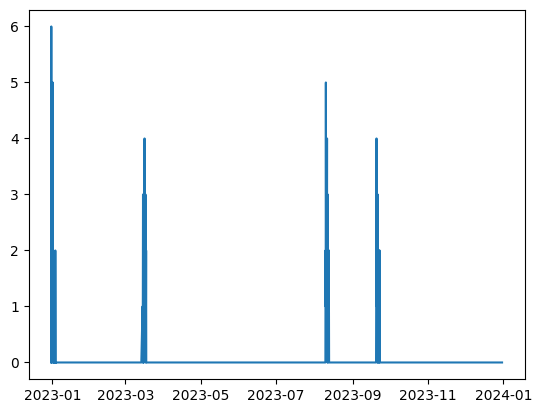

In [4]:
data['Time']= pd.to_datetime(data['Time'])
plt.plot(data['Time'], data['No. of Cases'])

In [5]:
from copy import deepcopy as dc 

def prepare_dataframe_for_lstm(df, n_steps):
    df= dc(df)
    
    
    df.set_index('Time', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'No. of Cases{i}']= df['No. of Cases'].shift(i)
        
        
        
    df.dropna(inplace=True)
    return df

lookback= 7
shifted_data= prepare_dataframe_for_lstm(data, lookback)
shifted_data.head()

,No. of Cases,No. of Cases1,No. of Cases2,No. of Cases3,No. of Cases4,No. of Cases5,No. of Cases6,No. of Cases7
Time,,,,,,,,
2022-12-31 21:00:00,1.0,1.0,0.0,1.0,0.0,1.0,6.0,0.0
2023-01-01 00:00:00,2.0,1.0,1.0,0.0,1.0,0.0,1.0,6.0
2023-01-01 03:00:00,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0
2023-01-01 06:00:00,1.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0
2023-01-01 07:00:00,5.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0


In [6]:
shifted_df_as_numpy= shifted_data.to_numpy()
shifted_df_as_numpy


array([[1., 1., 0., ..., 1., 6., 0.],
       [2., 1., 1., ..., 0., 1., 6.],
       [1., 2., 1., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_numpy= scaler.fit_transform(shifted_df_as_numpy)
shifted_df_as_numpy

array([[-0.6       , -0.6       , -1.        , ..., -0.6       ,
         1.        , -1.        ],
       [-0.2       , -0.6       , -0.6       , ..., -1.        ,
        -0.66666667,  1.        ],
       [-0.6       , -0.2       , -0.6       , ..., -0.6       ,
        -1.        , -0.66666667],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

In [8]:
x= shifted_df_as_numpy[:, 1:]
y= shifted_df_as_numpy[:, 0]

x.shape, y.shape

((443, 7), (443,))

In [9]:
x= dc(np.flip(x, axis=1))
x

array([[-1.        ,  1.        , -0.6       , ..., -0.6       ,
        -1.        , -0.6       ],
       [ 1.        , -0.66666667, -1.        , ..., -1.        ,
        -0.6       , -0.6       ],
       [-0.66666667, -1.        , -0.6       , ..., -0.6       ,
        -0.6       , -0.2       ],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

In [10]:
split= int(0.95 * len(x))
split

420

In [11]:
x_train= x[:split]
x_test= x[split:]
y_train= y[:split]
y_test= y[split:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((420, 7), (420,), (23, 7), (23,))

In [12]:
X_train = x_train.reshape((-1, lookback, 1))
X_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape, X_test.shape, y_train. shape, y_test.shape

((420, 7, 1), (23, 7, 1), (420, 1), (23, 1))

In [13]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test= torch.tensor(X_test).float()
y_test =torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train. shape, y_test.shape

(torch.Size([420, 7, 1]),
 torch.Size([23, 7, 1]),
 torch.Size([420, 1]),
 torch.Size([23, 1]))

In [14]:
from torch.utils.data import Dataset 

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x= x
        self.y= y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds= TimeSeriesDataset(X_train, y_train)
test_ds= TimeSeriesDataset(X_test, y_test)

In [15]:
train_ds

In [16]:
from torch.utils.data import DataLoader

batch_size= 16

train_loader= DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [17]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch= batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn. LSTM(input_size, hidden_size, num_stacked_layers,
        batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1,4,1).to(device)
model   

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
def train_one_epoch():
    model.train (True)
    print('Epoch: {epoch + 1}')
    running_loss= 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch= batch[0].to(device), batch [1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
        if batch_index % 10 == 9: # print every 100 batches
            avg_loss_across_batches= running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,avg_loss_across_batches))
            running_loss = 0.0
print()

In [20]:
def validate_one_epoch():
    model.train (False)
    running_loss= 0.0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch=batch[0].to(device), batch [1].to(device)
        with torch.no_grad():
            output= model(x_batch)
            loss= loss_function(output, y_batch)
            running_loss += loss
    avg_loss_across_batches = running_loss / len(test_loader)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('******************************')
    print()

In [21]:
learning_rate=0.001
num_epochs = 40
loss_function = nn.MSELoss()
optimizer = torch.optim. Adam (model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: {epoch + 1}
Batch 10, Loss: 0.107
Batch 20, Loss: 0.095
Val Loss: 0.988
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.081
Batch 20, Loss: 0.072
Val Loss: 0.755
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.061
Batch 20, Loss: 0.056
Val Loss: 0.532
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.045
Batch 20, Loss: 0.037
Val Loss: 0.315
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.026
Batch 20, Loss: 0.024
Val Loss: 0.141
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.015
Batch 20, Loss: 0.012
Val Loss: 0.046
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.011
Batch 20, Loss: 0.008
Val Loss: 0.015
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.007
Batch 20, Loss: 0.010
Val Loss: 0.008
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.007
Batch 20, Loss: 0.008
Val Loss: 0.007
******************************

E

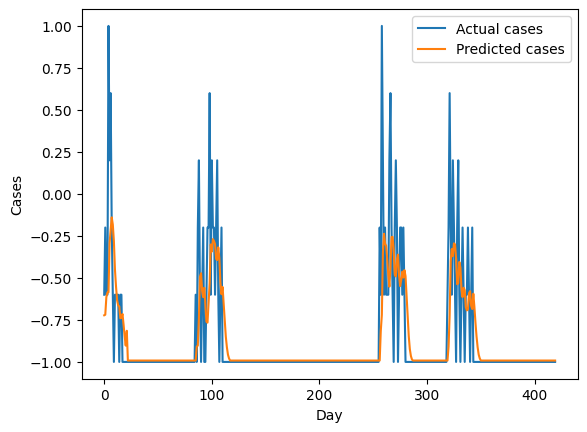

In [22]:
with torch.no_grad():
    predicted = model (X_train.to(device)).to('cpu').numpy()
    
plt.plot(y_train, label='Actual cases')
plt.plot(predicted, label='Predicted cases')
plt.xlabel('Day')
plt.ylabel('Cases')
plt.legend()
plt.show()

In [23]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([0.69396526, 0.70261568, 0.96261129, 1.03294313, 1.03814393,
       1.76679879, 1.9560463 , 2.15117138, 2.04419006, 1.79834217,
       1.37283698, 1.11838311, 0.9197858 , 0.83923936, 0.82865447,
       0.65004617, 0.65694273, 0.71362197, 0.5550766 , 0.37926584,
       0.24293989, 0.4632476 , 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060

In [24]:
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

C:\Users\MANAS KEDIA\AppData\Local\Temp\ipykernel_39736\2743067881.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([0.99999994, 1.99999999, 0.99999994, 0.99999994, 5.        ,
       3.00000001, 4.00000006, 1.99999999, 0.99999994, 0.        ,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.        ,
       0.99999994, 0.99999994, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

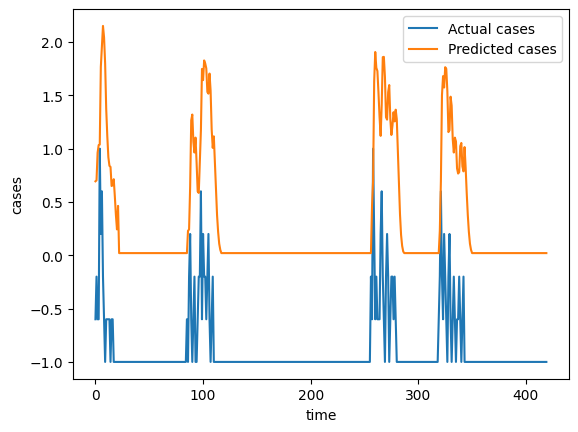

In [25]:
plt.plot(y_train, label='Actual cases')
plt.plot(train_predictions, label='Predicted cases')
plt.xlabel('time')
plt.ylabel('cases')
plt.legend()
plt.show() 

In [26]:
test_predictions = model (X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443, 0.02060443, 0.02060443,
       0.02060443, 0.02060443, 0.02060443])

In [27]:
dummies= np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

C:\Users\MANAS KEDIA\AppData\Local\Temp\ipykernel_39736\1929333245.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

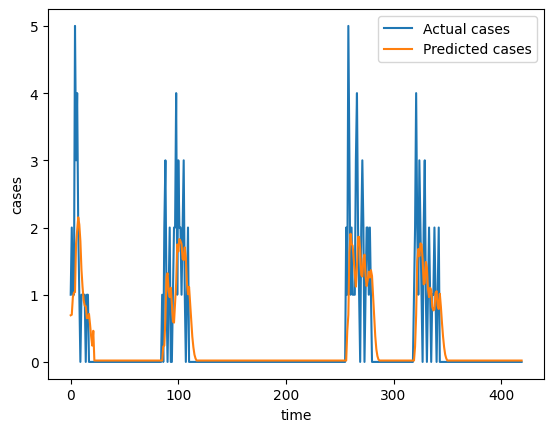

In [28]:
plt.plot(new_y_train, label='Actual cases')
plt.plot(train_predictions, label='Predicted cases')
plt.xlabel('time')
plt.ylabel('cases')
plt.legend()
plt.show() 

In [29]:

from io import StringIO

new_data = pd.read_csv('aligned_output_test.csv')

new_data['Time'] = pd.to_datetime(new_data['Time'])

shifted_new_data = prepare_dataframe_for_lstm(new_data, lookback)

shifted_new_data_as_numpy = shifted_new_data.to_numpy()
scaled_new_data_numpy = scaler.transform(shifted_new_data_as_numpy)

X_new = scaled_new_data_numpy[:, 1:]
y_new = scaled_new_data_numpy[:, 0]

X_new = dc(np.flip(X_new, axis=1))

X_new = X_new.reshape((-1, lookback, 1))

X_new_tensor = torch.tensor(X_new).float()

model.eval()
with torch.no_grad():
    new_predictions_scaled = model(X_new_tensor.to(device)).detach().cpu().numpy()

dummies = np.zeros((len(new_predictions_scaled), lookback + 1))
dummies[:, 0] = new_predictions_scaled.flatten()
final_predictions = scaler.inverse_transform(dummies)[:, 0]

print("\n--- Predictions on New Data ---")
prediction_times = shifted_new_data.index
for time, prediction in zip(prediction_times, final_predictions):
    predicted_cases = round(prediction)
    print(f"Time: {time}, Predicted Cases: {predicted_cases:.0f}")
    
    if predicted_cases > 1:
        alert_message = f"ALERT: Predicted case count exceeded 1.\nTime: {time}\nPredicted Cases: {predicted_cases:.0f}\n"
        with open('alert.txt', 'w') as f:
            f.write(alert_message)
        print("\n>>> Alert file 'alert.txt' has been generated! <<<")
        break

C:\Users\MANAS KEDIA\AppData\Local\Temp\ipykernel_39736\3189828793.py:5: FutureWarning: Parsed string "Saturday, December 31, 2022 12:00:00 A.M." included an un-recognized timezone "M". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  new_data['Time'] = pd.to_datetime(new_data['Time'])
C:\Users\MANAS KEDIA\AppData\Local\Temp\ipykernel_39736\3189828793.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  new_data['Time'] = pd.to_datetime(new_data['Time'])
C:\Users\MANAS KEDIA\AppData\Local\Temp\ipykernel_39736\3189828793.py:5: FutureWarning: Parsed string "Saturday, December 31, 2022 3:00:00 A.M." included an un-recognized timezone "M". Dropping unrecognized timezones is deprecated; in a future version this wil


--- Predictions on New Data ---
Time: 2022-12-31 21:00:00, Predicted Cases: 1
Time: 2023-01-01 00:00:00, Predicted Cases: 1
Time: 2023-01-01 03:00:00, Predicted Cases: 1
Time: 2023-01-01 06:00:00, Predicted Cases: 1
Time: 2023-01-01 07:00:00, Predicted Cases: 1
Time: 2023-01-01 07:30:00, Predicted Cases: 2

>>> Alert file 'alert.txt' has been generated! <<<
